In [1]:
from pathlib import Path
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is ready")

cuda is ready


In [3]:
DATA_DIR = Path("/workspace/data")
IMG_DIR = Path("/workspace/data/images/image_train")
X_train = pd.read_csv(DATA_DIR/"X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR/"Y_train_CVw08PX.csv", index_col=0)

df = X_train.join(Y_train, how="inner")

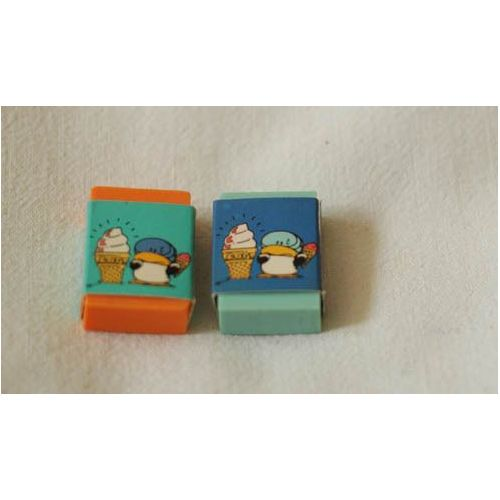

In [4]:
def get_img(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR/image_name)
    img_display = display(img)
    return img_display

get_img(84915)

In [5]:
preprocess = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [6]:
def get_img_data_by_index(index):
    row = df.iloc[index]
    image_name = f"image_{row['imageid']}_product_{row['productid']}.jpg"
    img = Image.open(IMG_DIR / image_name).convert("RGB")
    img_tensor = preprocess(img)

    return img_tensor

tensor_data = get_img_data_by_index(5)
display(f"return image shape: {tensor_data.shape}")

'return image shape: torch.Size([3, 224, 224])'

'image en gray shape: torch.Size([3, 224, 224])'

'valeur en gouche haute coin:'

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

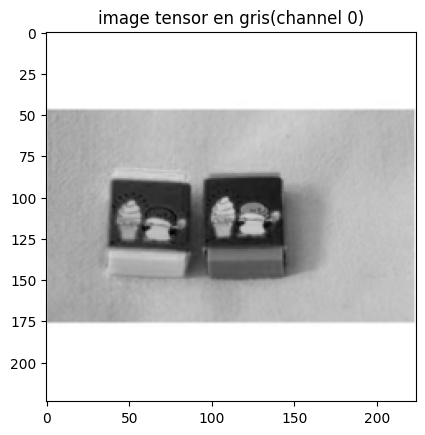

In [7]:
img_tensor = get_img_data_by_index(84915)

display(f"image en gray shape: {img_tensor.shape}")

display("valeur en gouche haute coin:")
display(img_tensor[0][0:6, 0:6])

plt.imshow(img_tensor[0], cmap="gray")
plt.title("image tensor en gris(channel 0)")
plt.show()

In [ ]:
# Manual convolution with Sobel kernels
kernel_vertical = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]])

kernel_horizontal = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]])

In [ ]:
def manual_convolution(img_tensor, kernel):

    # Get dimensions img_tensor, kernel_vertical
    channels, img_height, img_width = img_tensor.shape
    kernel_height, kernel_width = kernel_horizontal.shape

    # Calculate output dimensions for convolution
    output_height = img_height - kernel_height + 1
    output_width = img_width - kernel_width + 1

    # initialize output image
    output_img = np.zeros((output_height, output_width))
    
    # run convolution
    for i in range(output_height):
        for j in range(output_width):
            region = img_tensor[0, i:i+kernel_height, j:j+kernel_width].numpy()
            conv_value = np.sum(region * kernel)
            output_img[i, j] = conv_value

    return output_img

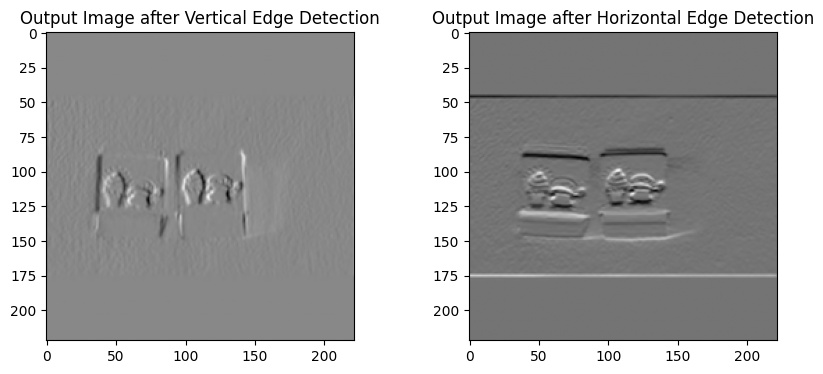

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_tensor, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_tensor, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

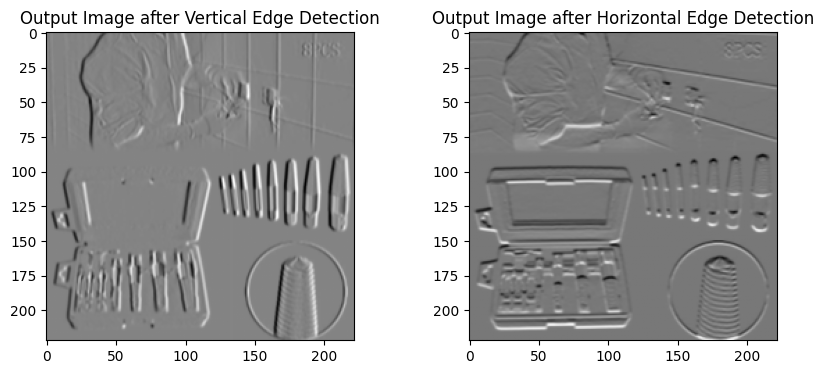

In [44]:
img_test = get_img_data_by_index(778)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(manual_convolution(img_test, kernel_vertical), cmap='gray')
axes[0].set_title("Output Image after Vertical Edge Detection")
axes[1].imshow(manual_convolution(img_test, kernel_horizontal), cmap='gray')
axes[1].set_title("Output Image after Horizontal Edge Detection")
result = plt.show()

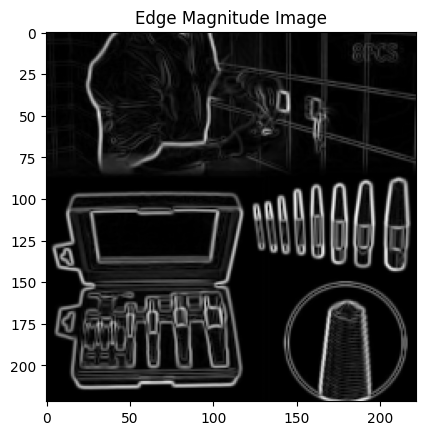

In [45]:
edge_v = manual_convolution(img_test, kernel_vertical)
edge_h = manual_convolution(img_test, kernel_horizontal)
edge_magnitude = np.sqrt(edge_v**2 + edge_h**2)
magnitude_fig = plt.imshow(edge_magnitude, cmap='gray')
plt.title("Edge Magnitude Image")
plt.show()

Before Pooling: (222, 222)
After Pooling: (111, 111)


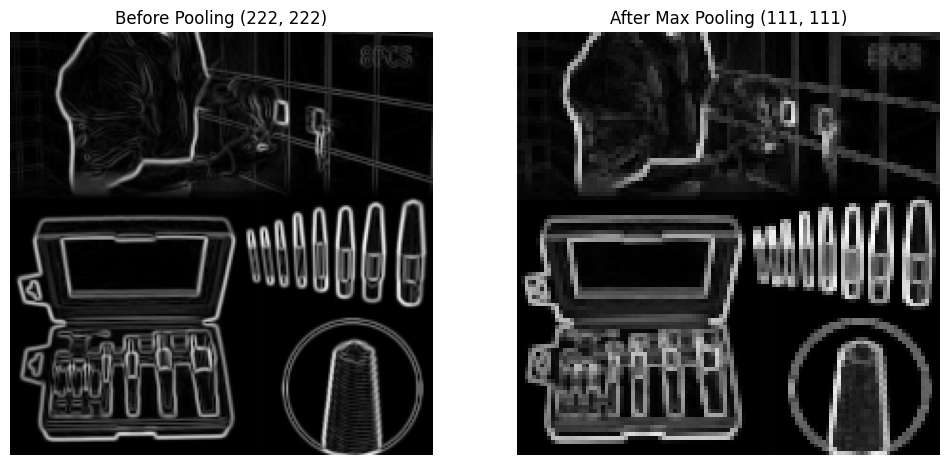

In [47]:
# pooling operation manually
def manual_max_pooling(feature_map, pool_size=2, stride=2):
    
    h, w = feature_map.shape
    
    out_h = (h - pool_size) // stride + 1
    out_w = (w - pool_size) // stride + 1
    
    output = np.zeros((out_h, out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            r_start = i * stride
            r_end = r_start + pool_size
            c_start = j * stride
            c_end = c_start + pool_size
            
            region = feature_map[r_start:r_end, c_start:c_end]
            
            output[i, j] = np.max(region)
            
    return output

print(f"Before Pooling: {edge_magnitude.shape}")

pooled_edge = manual_max_pooling(edge_magnitude, pool_size=2, stride=2)

print(f"After Pooling: {pooled_edge.shape}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edge_magnitude, cmap='gray')
plt.title(f"Before Pooling {edge_magnitude.shape}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pooled_edge, cmap='gray')
plt.title(f"After Max Pooling {pooled_edge.shape}")
plt.axis('off')

plt.show()